In [46]:
%load_ext autoreload
%autoreload 2
import os
import sys
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import json

# Objective:
# set up baseline for our method
# 
# Should have summary of the weekly progress

with open("./weights/18_256_cutmix_no_lrsc_/18_256_cutmix_no_lrsc_history.json", 'r') as f:
    # patch-based aug.: cutmix, pizzlemix, mixup, our method
    cutmix = json.load(f)

with open("./weights/18_256_cutout_/18_256_cutout_history.json", 'r') as f:
    # dropout-based aug.
    # making features absent, use black pixel to replace original 
    cutout = json.load(f)

with open("./weights/18_256_no_lrsc_/18_256_no_lrsc_history.json", 'r') as f:
    vanilla =json.load(f)[:100]

with open("./weights/18_256_t1_/18_256_t1_history.json", 'r') as f:
    # geo.-based aug.
    t1 = json.load(f)

with open("./weights/18_256_t2_/18_256_t2_history.json", 'r') as f:
    # color-based aug.
    t2 = json.load(f)
    
# what about the combo aug. 
# search diffusion for augmentation
# where diffusion is?

# how the sota xAI interpret the negative gradient (XAI exp);
# 1. useless;
# 2. depends on the context (model, dataset) (task specific);
# 3. useful;

In [37]:
cutmix[0]

{'epoch': 1,
 'train_batch_count': 157,
 'valid_batch_count': 4,
 'dur': 69.2158100605011,
 'train_loss': 1.0616975581949495,
 'train_loss_best': True,
 'valid_loss': 0.7805132328537462,
 'valid_loss_best': True,
 'valid_acc': 0.7512953367875648,
 'valid_acc_best': True,
 'valid_f1': 0.3987702773417059,
 'valid_f1_best': True,
 'event_cp': True}

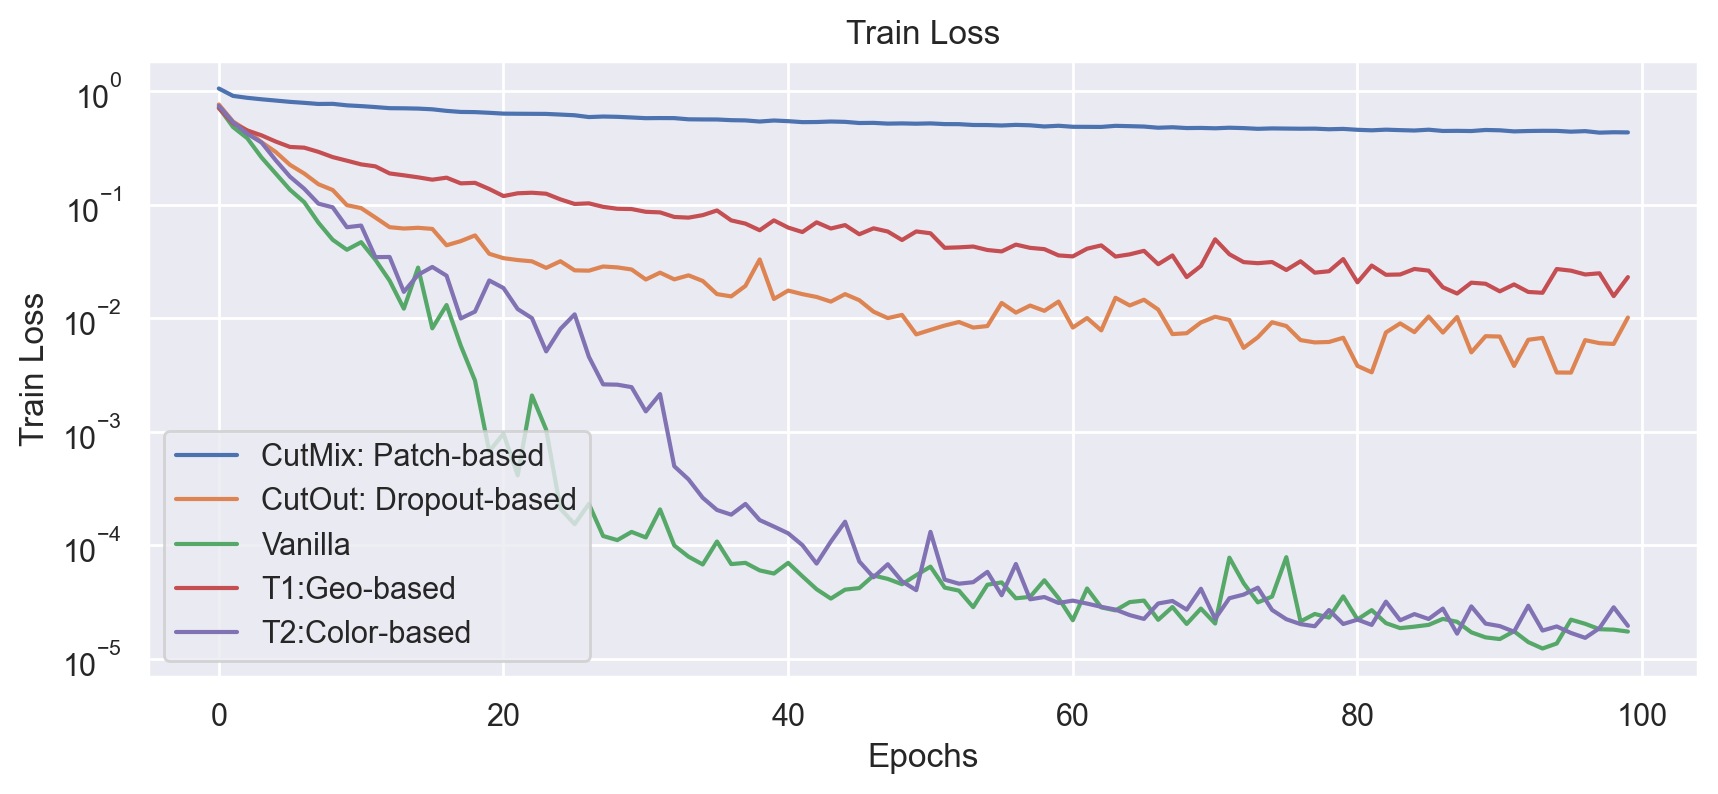

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

epochs = [i for i in range(len(cutmix))]


fig, ax = plt.subplots( dpi = 200, figsize=(10, 4))
plt.title('Train Loss')
ax.plot(epochs, [e['train_loss'] for e in cutmix], label="CutMix: Patch-based")
ax.plot(epochs, [e['train_loss'] for e in cutout], label="CutOut: Dropout-based")
ax.plot(epochs, [e['train_loss'] for e in vanilla], label="Vanilla")
ax.plot(epochs, [e['train_loss'] for e in t1], label="T1:Geo-based")
ax.plot(epochs, [e['train_loss'] for e in t2], label="T2:Color-based")
ax.set_yscale('log')
ax.set_xlabel('Epochs')
ax.set_ylabel('Train Loss')
ax.legend()
plt.show()

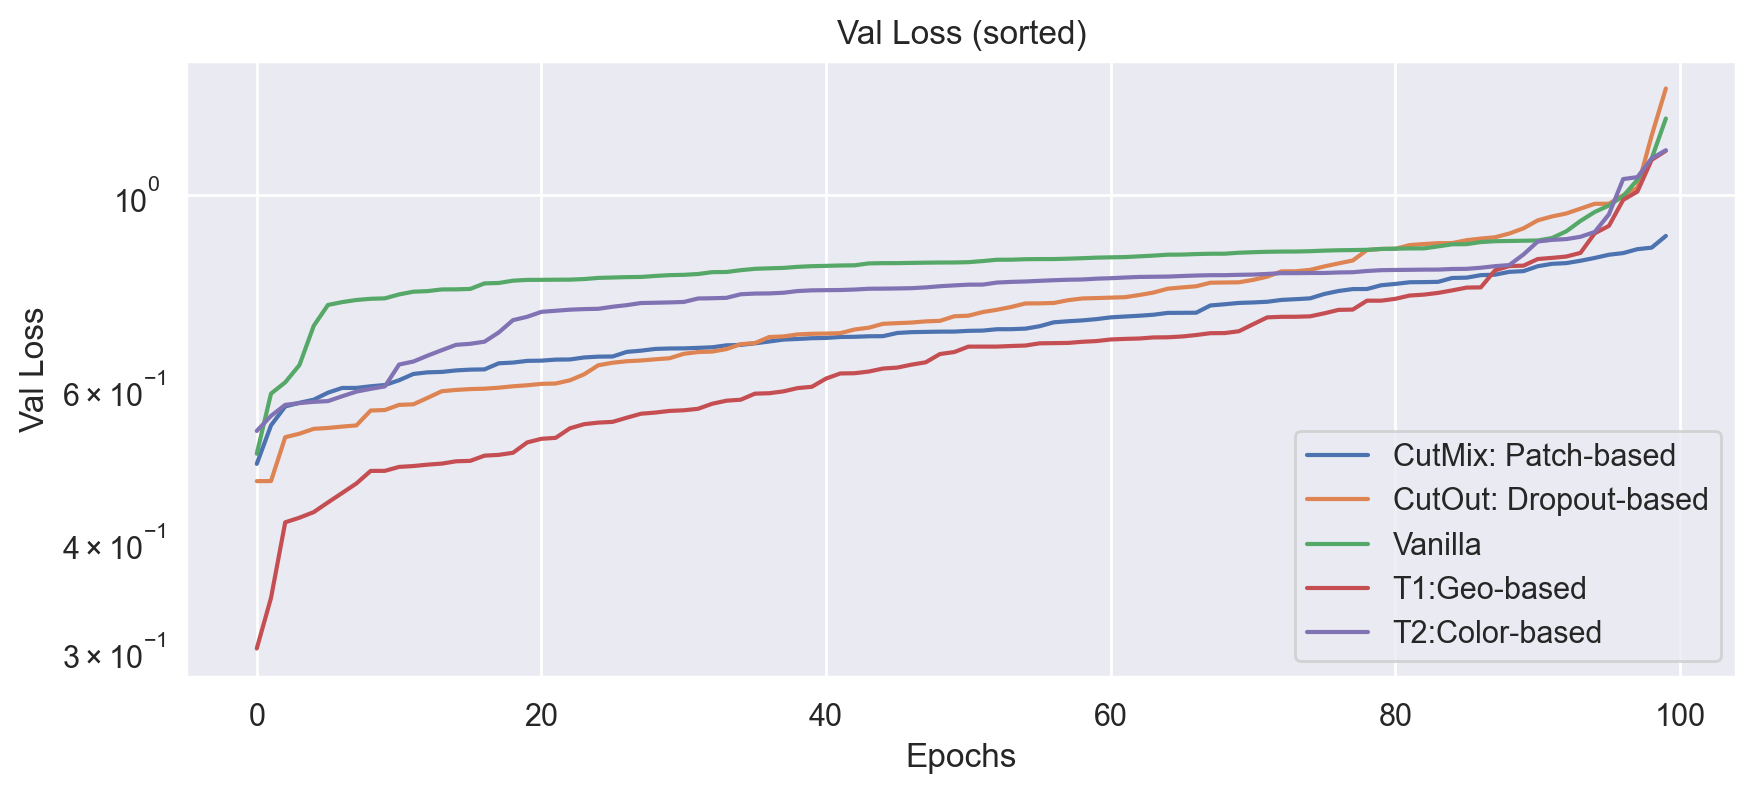

In [75]:
fig, ax = plt.subplots( dpi = 200, figsize=(10, 4))
plt.title('Val Loss (sorted)')
ax.plot(epochs, np.sort([e['valid_loss'] for e in cutmix]), label="CutMix: Patch-based")
ax.plot(epochs, np.sort([e['valid_loss'] for e in cutout]), label="CutOut: Dropout-based")
ax.plot(epochs, np.sort([e['valid_loss'] for e in vanilla]), label="Vanilla")
ax.plot(epochs, np.sort([e['valid_loss'] for e in t1]), label="T1:Geo-based")
ax.plot(epochs, np.sort([e['valid_loss'] for e in t2]), label="T2:Color-based")
ax.set_xlabel('Epochs')
ax.set_yscale('log')
ax.set_ylabel('Val Loss')
ax.legend()
plt.show()

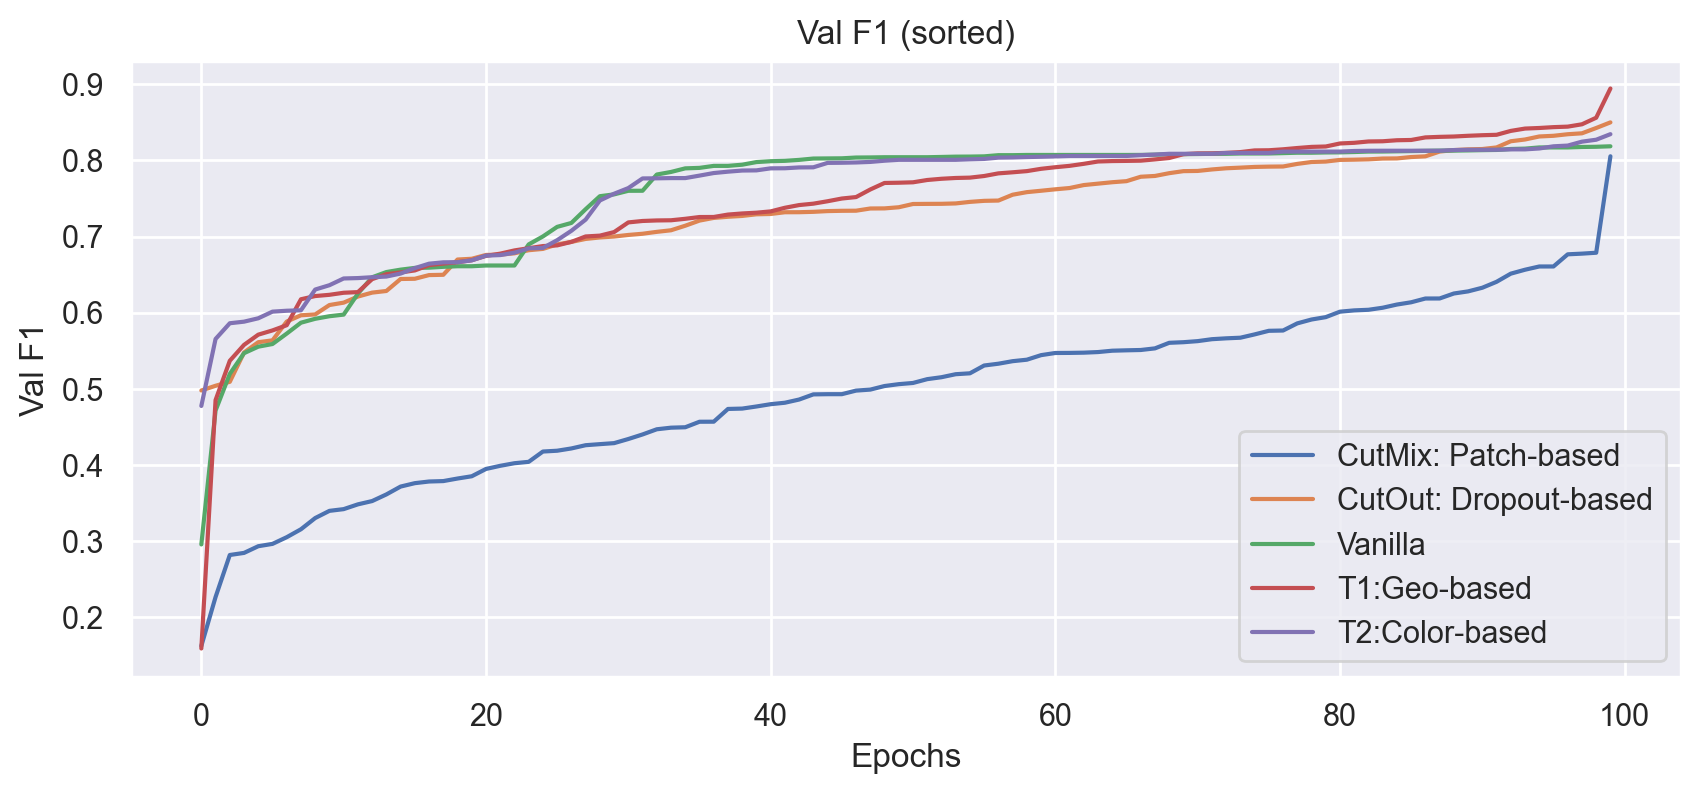

In [74]:
fig, ax = plt.subplots( dpi = 200, figsize=(10, 4))
plt.title('Val F1 (sorted)')
ax.plot(epochs, np.sort([e['valid_f1'] for e in cutmix]), label="CutMix: Patch-based")
ax.plot(epochs, np.sort([e['valid_f1'] for e in cutout]), label="CutOut: Dropout-based")
ax.plot(epochs, np.sort([e['valid_f1'] for e in vanilla]), label="Vanilla")
ax.plot(epochs, np.sort([e['valid_f1'] for e in t1]), label="T1:Geo-based")
ax.plot(epochs, np.sort([e['valid_f1'] for e in t2]), label="T2:Color-based")
ax.set_xlabel('Epochs')
ax.set_ylabel('Val F1')
ax.legend()
plt.show()

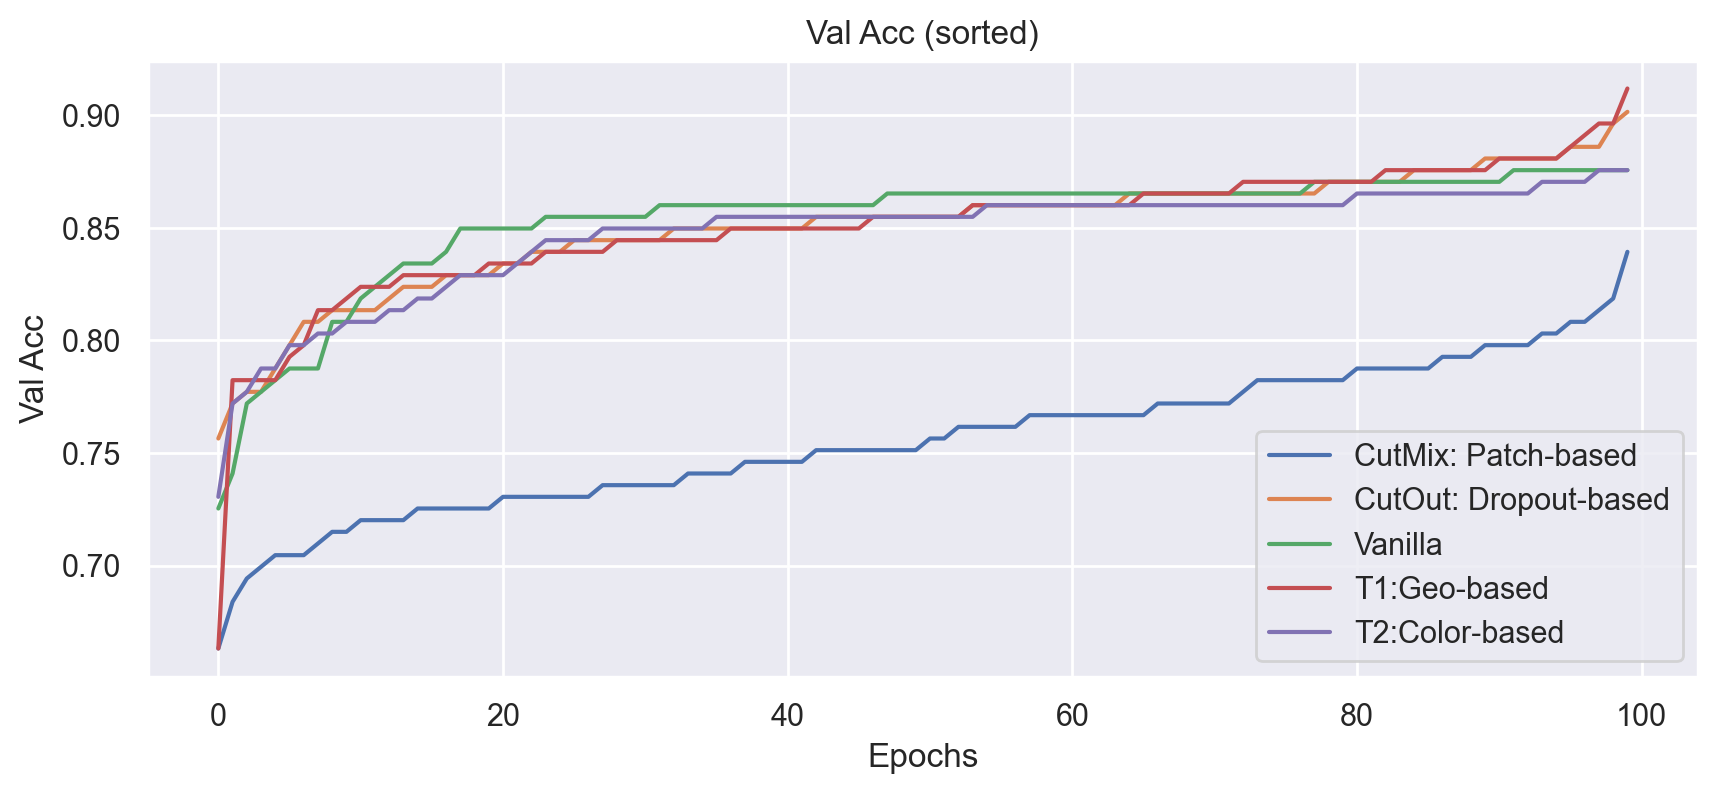

In [73]:
fig, ax = plt.subplots( dpi = 200, figsize=(10, 4))
plt.title('Val Acc (sorted)')
ax.plot(epochs, np.sort([e['valid_acc'] for e in cutmix]), label="CutMix: Patch-based")
ax.plot(epochs, np.sort([e['valid_acc'] for e in cutout]), label="CutOut: Dropout-based")
ax.plot(epochs, np.sort([e['valid_acc'] for e in vanilla]), label="Vanilla")
ax.plot(epochs, np.sort([e['valid_acc'] for e in t1]), label="T1:Geo-based")
ax.plot(epochs, np.sort([e['valid_acc'] for e in t2]), label="T2:Color-based")
ax.set_xlabel('Epochs')
ax.set_ylabel('Val Acc')
ax.legend()
plt.show()

Observation:
1. Patch-based method performs worst;
2. Vanilla and Color-based are highly similar: Overfit;
3. Geo-based and Dropout-based perform well compared with others;
4. Geo-based performs the best;

Facts:
1. Patch-based performs better than Dropout-based in CIFAR-100 (100), ImageNet (1k) (CutMix paper, PuzzleMix paper)

The performance of augmentation techniques depends on the context:
1. CIFAR-100 (100) ImageNet datasetshas internal abstraction
2. ISIC dataset has internal abstraction
3. XRay dataset has internal abstraction

Assumptions:
- Uncertainty:
    1. Patched-based introduces uncertainty to the class discrimination (adding entropy regarding features) during the training;
    2. Geo-based and Dropout-based reduce the uncertainty;
    3. Color-based doesn't change the entropy much;
    
- Factors of Model ability to learn from the Uncertainty:
    1. Similarity between classes (features)
        (color is not important, as we observed, 
            so the color features get relatively higher similarity, so is hard for the model to learn);
        (shape is important, as we observed, 
            so the shape features get relatively less similarity, so is easier for the model to learn);
    2. Number of class labels;
    3. Classes are imbalanced;
    4. Size of the dataset;
    4. Size of the training epoch;

Next:
1. introduce another patch-based: MixUp or PuzzleMix (read puzzlemix: gradient XAI + data aug) + search diffusion based augmentation method (3 days);
2. derive mix strategy from the last work;